In [22]:
%matplotlib inline

## DataProvider

In [23]:
import os

import fastremap
import h5py
import numpy as np

In [24]:
home = os.path.expanduser("~")
root = os.path.join(home, "Data/public/CREMI")

In [25]:
def load_data(data_id):
    sample_path = os.path.join(root, f"sample_{data_id}_20160501.hdf")
    with h5py.File(sample_path, "r") as f:
        # Image
        img = f["volumes"]["raw"][...].astype(np.float32)
        img /= 255.
    
        # Segmentation
        seg = f["volumes"]["labels"]["neuron_ids"][...]
        seg, _ = fastremap.renumber(seg, in_place=True)
        seg = seg.astype(np.uint32)
    
        # Mask    
        msk = np.ones_like(seg, dtype=np.uint8)
        
        return img, seg, msk

In [26]:
data_id = "B"

In [27]:
img, seg, msk = load_data(data_id)

In [28]:
import matplotlib.pyplot as plt

def plot_data(img, seg, msk):
    sz = 10
    fig = plt.figure(figsize=(sz,sz))

    plt.subplot(131)
    z = img.shape[-3]//2
    plt.imshow(img[z,:,:], cmap='gray')

    plt.subplot(132)
    z = img.shape[-3]//2
    plt.imshow(seg[z,:,:])

    plt.subplot(133)
    z = img.shape[-3]//2
    plt.imshow(msk[z,:,:], cmap='gray')
    plt.show()

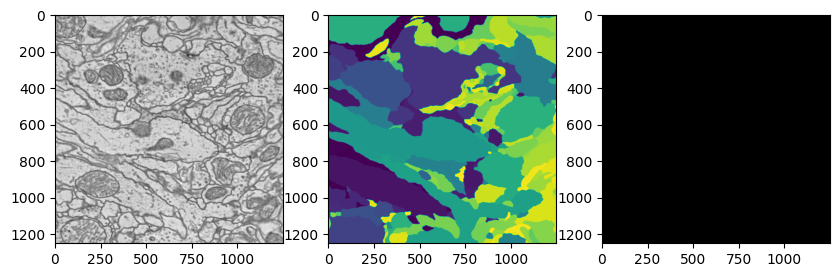

In [29]:
plot_data(img, seg, msk)

In [30]:
from dataprovider3 import Dataset, DataProvider

In [31]:
# Create Dataset.
dset = Dataset()
dset.add_data('img', img)
dset.add_data('seg', seg)
dset.add_mask('msk', msk, loc=True)

In [32]:
# Create DataProvider
shape = (20, 256, 256)
spec = dict(img=shape, seg=shape, msk=shape)
dp = DataProvider(spec)
dp.add_dataset(dset)
dp.set_imgs(['img'])
dp.set_segs(['seg'])

## Augmentor

In [33]:
import matplotlib
import matplotlib.pyplot as plt

def plot_seg(seg, border=False):
    unique, unique_inverse = np.unique(seg, return_inverse=True)
    N = len(unique)
    cmap = np.random.rand(N,3)
    if border:
        cmap[0,:] = 0
    cmap = matplotlib.colors.ListedColormap(cmap)
    plt.imshow(np.arange(N)[unique_inverse].reshape(seg.shape), cmap=cmap)

In [34]:
import augmentor
from augmentor import Border

In [35]:
aug = Border()
print(aug)

Border()


In [36]:
dp.set_augment(aug)

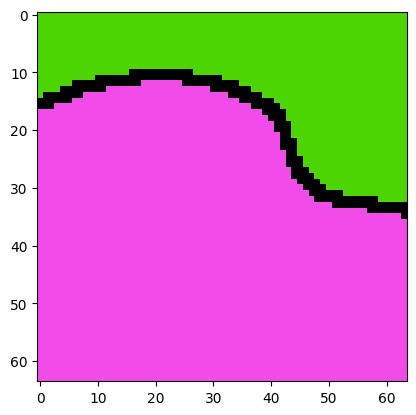

In [40]:
sample = dp()
seg = sample["seg"][0, 0, :64, :64]
plot_seg(seg, border=True)